In [1]:
import sys,csv,os
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import itertools
import lmfit,corner
from astropy.table import Table, Column
from astropy.convolution import Gaussian2DKernel
from astropy.visualization import MinMaxInterval,SqrtStretch,AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import make_lupton_rgb
from morphsed import Galaxy, AGN, sed_to_obse
import morphsed.emission_lines as EL
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM,z_at_value
from astropy.stats import sigma_clipped_stats
from astropy.visualization.mpl_normalize import simple_norm

In [2]:
targname = '2'
Band = ['g','r','i','z','y']
phys_to_image ={
    'g'  : 2.12e18,  #4810
    'r'  : 3.50e18,  #6170
    'i'  : 5.20e18,  #7520
    'z'  : 6.89e18,  #8660
    'y'  : 8.50e18,  #9620
    #counts_rate/flux
}
phys_to_counts_rate = np.ones(5,dtype=float)
filepath = '/Users/liruancun/Works/GitHub/MorphSED/examples/data/test/'
images = []
psfs = []
for loop,band in enumerate(Band):
    hdu = fits.open(filepath + '{0}_{1}.fits'.format(targname,band))
    header = hdu[0].header
    data_ory = np.array(hdu[0].data)
    ny,nx=data_ory.shape
    imcut = data_ory[int(0.5*ny)-45:int(0.5*ny)+45,int(0.5*nx)-45:int(0.5*nx)+45]
    images.append(imcut/header['EXPTIME'])
    sky_mean, sky_median, sky_std = sigma_clipped_stats(imcut, sigma=3.0, maxiters=5)
    GAIN = header['CELL.GAIN']
    sigma_map = np.sqrt(imcut/GAIN+sky_std**2)/header['EXPTIME']
    if loop == 0:
        images_sigma = sigma_map.ravel()
    else:
        images_sigma = np.append(images_sigma,sigma_map.ravel())
    hdu = fits.open(filepath + '{0}_{1}_psf.fits'.format(targname,band))
    psfs.append(np.array(hdu[0].data))
z = 0.301712
ebv = 0.0341
cosmo = FlatLambdaCDM(H0=67.8 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.308)
d=cosmo.luminosity_distance(z)
dc=d.to(u.cm)
dis=dc.value
C_unit=1./(4*np.pi*dis**2)
for loop in range(5):
    phys_to_counts_rate[loop] = phys_to_image[Band[loop]]*C_unit
ny,nx = images[0].shape
spec = Table.read(filepath+'spec_{0}.txt'.format(targname),format='ascii')
spec['Intensity'] /= (C_unit*1e17)
spec['Uncertainty'] /= (C_unit*1e17)
spec = [np.array(spec['Spectral-axis']),np.array(spec['Intensity']),np.array(spec['Uncertainty'])]

In [3]:
par_total = lmfit.Parameters()
par_total.add('logM', 10.74 , min=8., max=13.)
sesicparam = ['x', 'y', 'Re', 'n', 'ang', 'axrat']
par_total.add('BoT', value=0.3, min=0.05, max=0.95)
par_total.add('sersic1_x', value=46, min=41., max=51)
par_total.add('sersic1_y', value=46, min=41., max=51)
par_total.add('sersic1_Re', value=0.5, min=0.1, max=1.5)
par_total.add('sersic1_n', value=3., min=1., max=6.)
par_total.add('sersic1_ang', value=0., min=-90., max=90.,vary=False)
par_total.add('sersic1_axrat', value=1, min=0.2, max=1.,vary=False)
par_total.add('sersic1_f_cont', value=0.5, min=0., max=1.)
par_total.add('sersic1_age', value=5., min=0.1, max=13.)
par_total.add('sersic1_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic1_Av', value=0.7, min =0.3, max=5.1)
par_total.add('sersic2_x', expr='1.*sersic1_x')
par_total.add('sersic2_y', expr='1.*sersic1_y')
par_total.add('sersic2_Re', value=10., min=3., max=25.)
par_total.add('sersic2_n', value=1., vary=False)
par_total.add('sersic2_ang', value=-20., min=-90., max=90.)
par_total.add('sersic2_axrat', value=0.8, min=0.2, max=1.)
par_total.add('sersic2_f_cont', value=0.5, min=0., max=1.)
par_total.add('sersic2_age', value=1., min=0.1, max=13.)
par_total.add('sersic2_Z', value=0.02, min=0.001, max=0.04,vary=False)
par_total.add('sersic2_Av', value=0.7, min =0.3, max=5.1)
par_total.add('agn_x', expr='1.*sersic1_x')
par_total.add('agn_y', expr='1.*sersic1_y')
par_total.add('agn_logM', value=7.85, min=5., max=10.,vary=False)
par_total.add('agn_logLedd', value=-1, min=-4, max=2.)
par_total.add('agn_spin', value=0., min=0., max=0.99,vary=False)
par_total.add('agn_Av', value=0., min =0., max=3.1,vary=False)
par_total.add('sky_g', value=0., min =-1., max=1.)
par_total.add('sky_r', value=0., min =-1., max=1.)
par_total.add('sky_i', value=0., min =-1., max=1.)
par_total.add('sky_z', value=0., min =-1., max=1.)
par_total.add('sky_y', value=0., min =-1., max=1.)
par_total.add('N_agn', value=1., min =0.1, max=10.)
par_total.add('N_gal', value=1., min =0.1, max=10.)
Myagn = AGN(logM_BH=par_total['agn_logM'].value,logLedd= par_total['agn_logLedd'].value,
                    astar=par_total['agn_spin'].value,Av =par_total['agn_Av'].value, z=z, ebv_G=ebv)
lines_broad = [EL.Hg,EL.Hb,EL.Ha]
lines_narrow = [EL.NeV,EL.NeVI,EL.OII,EL.NeIII,EL.Hg,EL.Hb,EL.Ha,EL.OIII_4959,EL.OIII_5007,EL.HeI,
                EL.OI_6302,EL.NII_6549,EL.NII_6583,EL.SII_6716,EL.SII_6731]
par_BLR,par_NLR = Myagn.set_full_model(spec,lines_broad,lines_narrow)
par_total = par_total.update(par_BLR)
par_total = par_total.update(par_NLR)
par_total['BaCfwhm'].set(expr='61.69*Hbb1fwhm')

In [4]:
def residualcon(parc):
    Mygalaxy = Galaxy(mass = 10**parc['logM'].value, z=z, ebv_G=ebv)
    Myagn.reset_BH(logM_BH=parc['agn_logM'].value,logLedd= parc['agn_logLedd'].value,
                astar=parc['agn_spin'].value,Av =parc['agn_Av'].value)
    strucure_para = {'xcen': parc['sersic1_x'].value, 'ycen': parc['sersic1_y'].value,
                     'frac': 100.*parc['BoT'], 're': parc['sersic1_Re'].value, 'nser': parc['sersic1_n'].value,
                     'ang': parc['sersic1_ang'].value, 'axrat': parc['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
    age = {'type': "const", 'paradic':{'value': parc['sersic1_age'].value}}
    Z = {'type': "const", 'paradic':{'value':  parc['sersic1_Z'].value}}
    f_cont = {'type': "const", 'paradic':{'value': parc['sersic1_f_cont'].value}}
    Av = {'type': "const", 'paradic':{'value': parc['sersic1_Av'].value}}
    Mygalaxy.add_subC('sersic',strucure_para,age,Z,f_cont,Av)
    strucure_para = {'xcen': parc['sersic2_x'].value, 'ycen': parc['sersic2_y'].value,
                     'frac': 100.*(1.-parc['BoT']), 're': parc['sersic2_Re'].value, 'nser': parc['sersic2_n'].value,
                     'ang': parc['sersic2_ang'].value, 'axrat': parc['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
    age = {'type': "const", 'paradic':{'value': parc['sersic2_age'].value}}
    Z = {'type': "const", 'paradic':{'value':  parc['sersic2_Z'].value}}
    f_cont = {'type': "const", 'paradic':{'value': parc['sersic2_f_cont'].value}}
    Av = {'type': "const", 'paradic':{'value': parc['sersic2_Av'].value}}
    Mygalaxy.add_subC('sersic',strucure_para,age,Z,f_cont,Av)
    totalmass = Mygalaxy.generate_mass_map((ny,nx),np.array(psfs[0]))
    agnlocaltion = {'xcen': parc['agn_x'].value, 'ycen': parc['agn_y'].value,}
    residual_image=[]
    for loop in range(5):
        band = Band[loop]
        image = Mygalaxy.generate_image('panstarrs_{0}'.format(band),psfs[loop])
        image += Myagn.generate_image([ny,nx],'panstarrs_{0}'.format(band),psfs[loop],agnlocaltion,par_tot=parc)
        image *= phys_to_counts_rate[loop]
        image += np.ones_like(image)*parc['sky_{0}'.format(band)].value
        residual_image.append(images[loop]-image)
    residu_flat = residual_image[0].ravel()
    for loop in range(4):
        residu_flat=np.append(residu_flat,residual_image[loop+1].ravel())
    residu_flat /= images_sigma
    fl,fll = Mygalaxy.fiducial_sed(spec[0])
    fl*= parc['N_gal'].value
    fl += parc['N_agn'].value*Myagn.fiducial_sed(spec[0],parc)
    residu_spec = (fl-spec[1])/spec[2]
    del (Mygalaxy)
    #del (Myagn)
    return np.append(residu_flat,residu_spec)

In [8]:
fitresult = lmfit.minimize(residualcon,par_total,nan_policy='omit' )

In [9]:
par_total = fitresult.params
bestpar = par_total.valuesdict()
w = csv.writer(open(filepath+"/bestpar_{0}.csv".format(targname), "w"))
for key, val in bestpar.items():
    w.writerow([key, val])
w = csv.writer(open(filepath+"/fake.csv", "w"))
Mygalaxy = Galaxy(mass = 10**par_total['logM'].value, z=z, ebv_G=ebv)
Myagn.reset_BH(logM_BH=par_total['agn_logM'].value,logLedd= par_total['agn_logLedd'].value,
            astar=par_total['agn_spin'].value,Av =par_total['agn_Av'].value)
strucure_para = {'xcen': par_total['sersic1_x'].value, 'ycen': par_total['sersic1_y'].value,
                 'frac': 100.*par_total['BoT'], 're': par_total['sersic1_Re'].value, 'nser': par_total['sersic1_n'].value,
                 'ang': par_total['sersic1_ang'].value, 'axrat': par_total['sersic1_axrat'].value, 'box': 0.0, 'convolve': False}
age = {'type': "const", 'paradic':{'value': par_total['sersic1_age'].value}}
Z = {'type': "const", 'paradic':{'value':  par_total['sersic1_Z'].value}}
f_cont = {'type': "const", 'paradic':{'value': par_total['sersic1_f_cont'].value}}
Av = {'type': "const", 'paradic':{'value': par_total['sersic1_Av'].value}}
Mygalaxy.add_subC('sersic',strucure_para,age,Z,f_cont,Av)
strucure_para = {'xcen': par_total['sersic2_x'].value, 'ycen': par_total['sersic2_y'].value,
                 'frac': 100.*(1.-par_total['BoT']), 're': par_total['sersic2_Re'].value, 'nser': par_total['sersic2_n'].value,
                 'ang': par_total['sersic2_ang'].value, 'axrat': par_total['sersic2_axrat'].value, 'box': 0.0, 'convolve': False}
age = {'type': "const", 'paradic':{'value': par_total['sersic2_age'].value}}
Z = {'type': "const", 'paradic':{'value':  par_total['sersic2_Z'].value}}
f_cont = {'type': "const", 'paradic':{'value': par_total['sersic2_f_cont'].value}}
Av = {'type': "const", 'paradic':{'value': par_total['sersic2_Av'].value}}
Mygalaxy.add_subC('sersic',strucure_para,age,Z,f_cont,Av)
totalmass = Mygalaxy.generate_mass_map((ny,nx),np.array(psfs[0]))

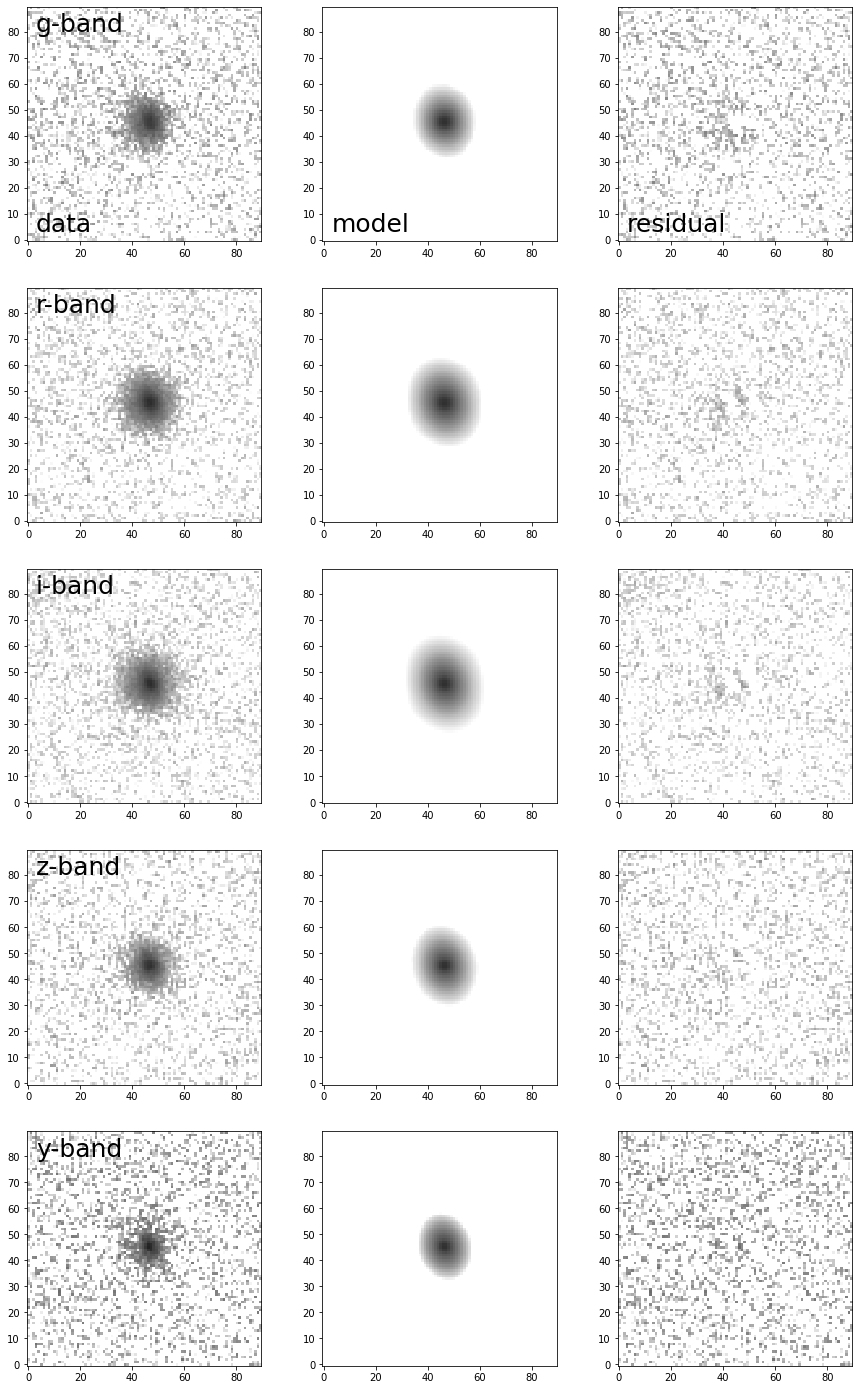

In [10]:
model_images = []
residual_image=[]
agnlocaltion = {'xcen': par_total['agn_x'].value, 'ycen': par_total['agn_y'].value,}
for loop in range(5):
    band = Band[loop]
    image = Mygalaxy.generate_image('panstarrs_{0}'.format(band),psfs[loop])
    image += Myagn.generate_image([ny,nx],'panstarrs_{0}'.format(band),psfs[loop],agnlocaltion,par_tot=par_total)
    image *= phys_to_counts_rate[loop]
    image += np.ones_like(image)*par_total['sky_{0}'.format(band)].value
    model_images.append(image)
    residual_image.append(images[loop]-image)

data_all = [images,model_images,residual_image]
shape=[ny,nx]
nrows = 5
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25),squeeze=True)
ax = ax.ravel()
fignumber=15
for i in range(nrows):
    sky_mean, sky_median, sky_std = sigma_clipped_stats(images[i], sigma=3.0, maxiters=5)
    norm = simple_norm([0.5*sky_std, 3*np.max(data_all[1][i])], 'log', percent=100)
    for j in range(ncols):
        ax[3*i+j].imshow(data_all[j][i], cmap='Greys', origin='lower', norm=norm,
                           interpolation='nearest')
    ax[3*i+0].text(3,80, "{0}-band".format(Band[i]), size = 25, color = 'k', weight = "light" )
ax[0].text(3,3, "data", size = 25, color = 'k', weight = "light" )
ax[1].text(3,3, "model", size = 25, color = 'k', weight = "light" )
ax[2].text(3,3, "residual", size = 25, color = 'k', weight = "light" )
plt.savefig(filepath+'{0}_multifit.png'.format(targname),dpi=200.,bbox_inches='tight')
plt.show()


In [14]:
#fitresult

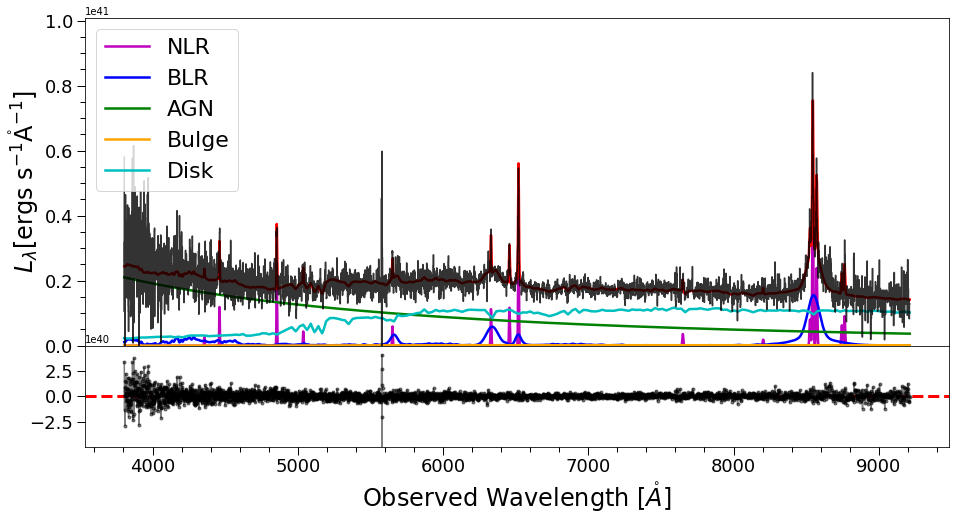

In [11]:
fl,fll = Mygalaxy.fiducial_sed(spec[0])
fl *= par_total['N_gal'].value
agnf = par_total['N_agn'].value*Myagn.fiducial_sed(spec[0],par_total)  
waveintrin = spec[0]/(1.+z)
if Myagn.Av > 0.:
    cm=extinction.ccm89(waveintrin,Myagn.Av,3.1)/2.5
else:
    cm = np.zeros_like(waveintrin)
x,nlrE = sed_to_obse(waveintrin,Myagn.NLR.eval(par_total,x=waveintrin)/10**cm,Myagn.redshift,Myagn.ebv_G)
x,blrE = sed_to_obse(waveintrin,Myagn.BLR.eval(par_total,x=waveintrin)/10**cm,Myagn.redshift,Myagn.ebv_G)


fig = plt.figure(figsize=(15, 7))
frame1=fig.add_axes((.15,.3,.8,.65)) # left, bottom, width, height
frame1.minorticks_on()
frame1.tick_params(axis="y", which="major", length=8, labelsize=18, width=1.)
frame1.tick_params(axis="y", which="minor", length=5, labelsize=18, width=1.)
frame1.tick_params(axis="x", labelsize=0.)

plt.plot(spec[0],par_total['N_agn'].value*nlrE,color='m',label='NLR',alpha=1.0,linewidth=2.5)
plt.plot(spec[0],par_total['N_agn'].value*blrE,color='b',label='BLR',alpha=1.0,linewidth=2.5)
plt.plot(spec[0],agnf - par_total['N_agn'].value*(blrE+nlrE),color='g',label='AGN',alpha=1.0,linewidth=2.5)

plt.plot(spec[0],par_total['N_gal'].value*fll[0],color='orange',label='Bulge',alpha=1.0,linewidth=2.5)
plt.plot(spec[0],par_total['N_gal'].value*fll[1],color='c',label='Disk',alpha=1.0,linewidth=2.5)

plt.plot(spec[0],fl+agnf,color='r',label='',alpha=1.0,linewidth=2.5)
plt.step(spec[0],spec[1],color='k',label='',alpha=0.8)

yliml=0.
ylimu=1.2*np.max(spec[1])
#ylimu=260
plt.ylim([yliml,ylimu])
#plt.xlim([3400,6985])
plt.ylabel(r'$L_{\lambda} \rm [ergs$ $\rm s^{-1} \mathring{A}^{-1}]$', fontsize=24)
plt.legend(loc='upper left',fontsize=22,numpoints=1)
resid=spec[1]-(fl+agnf)
frame2=fig.add_axes((.15,.1,.8,.2))
frame2.minorticks_on()
frame2.tick_params(axis="x", which="major", length=8, labelsize=18, width=1.)
frame2.tick_params(axis="x", which="minor", length=5, labelsize=18, width=1.)
frame2.tick_params(axis="y", which="major", length=8, labelsize=18, width=1.)
frame2.tick_params(axis="y", which="minor", length=0, labelsize=18, width=1.)
#plt.text(x=770,y=450,fontsize=26,s='Residuals',color='k')
plt.axhline(y=0., linestyle='--', color='r', label='',linewidth=3.)
plt.errorbar(spec[0],resid,marker='.',capsize=2,capthick=1,color='k',alpha=0.5)
ylim=0.75*np.max([np.max(np.abs(resid))])
plt.xlabel(r'Observed Wavelength $[\mathring{A}]$', fontsize=24)
#plt.xlim([3400,6985])
plt.ylim([-ylim,ylim])
plt.savefig(filepath + '/opfit.png',dpi=200,bbox_inches = 'tight')
plt.show()


In [11]:
stdhb = 0.2e41
par_total['FeIIA_uv'].set(0.7*stdhb/4000.,min=0.7*stdhb/400000.,max=0.7*stdhb/40.)
par_total['FeIIA_op'].set(stdhb/4000.,min=stdhb/400000.,max=stdhb/40.)

In [32]:
from morphsed import BaC

In [38]:
x = np.logspace(np.log10(3000),np.log10(9000),1000)
y = BaC(x,0.2,7.8,-0.67,0,0,8000)

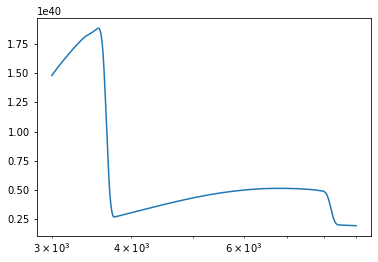

In [39]:

plt.xscale('log')

In [13]:
par_total['BaCcf'].set(0.02,min=0.,max=1.)